In [1]:
%env CUDA_VISIBLE_DEVICES=-1
%load_ext autoreload
%autoreload 2
from plot_utils import *
import sys
import os
from PIL import Image
import itertools

env: CUDA_VISIBLE_DEVICES=-1


In [2]:
datasets = ["bicycle","bonsai"]
eval_paths = {}
for exp in os.listdir("../output"):
        eval_paths[exp] = {"orig" : {}, "mini_s" : {}, "c3dgs" : {}}

        for ds in datasets:
            p = os.path.join("../output",exp,ds,"test","ours_30000")
            if os.path.exists(p):
                eval_paths[exp]["orig"][ds] = p
            
            p_mini = os.path.join("../output",exp,"mini_s",ds,"test","ours_30000")
            if os.path.exists(p_mini):
                eval_paths[exp]["mini_s"][ds] = p_mini

            p_c3dgs = os.path.join("../output",exp,"c3dgs",ds,"test","ours_35000")
            if os.path.exists(p_mini):
                eval_paths[exp]["c3dgs"][ds] = p_c3dgs

                
stats = load_stats(eval_paths)
normalized_stats,min_max = normalize_stats(stats,datasets)

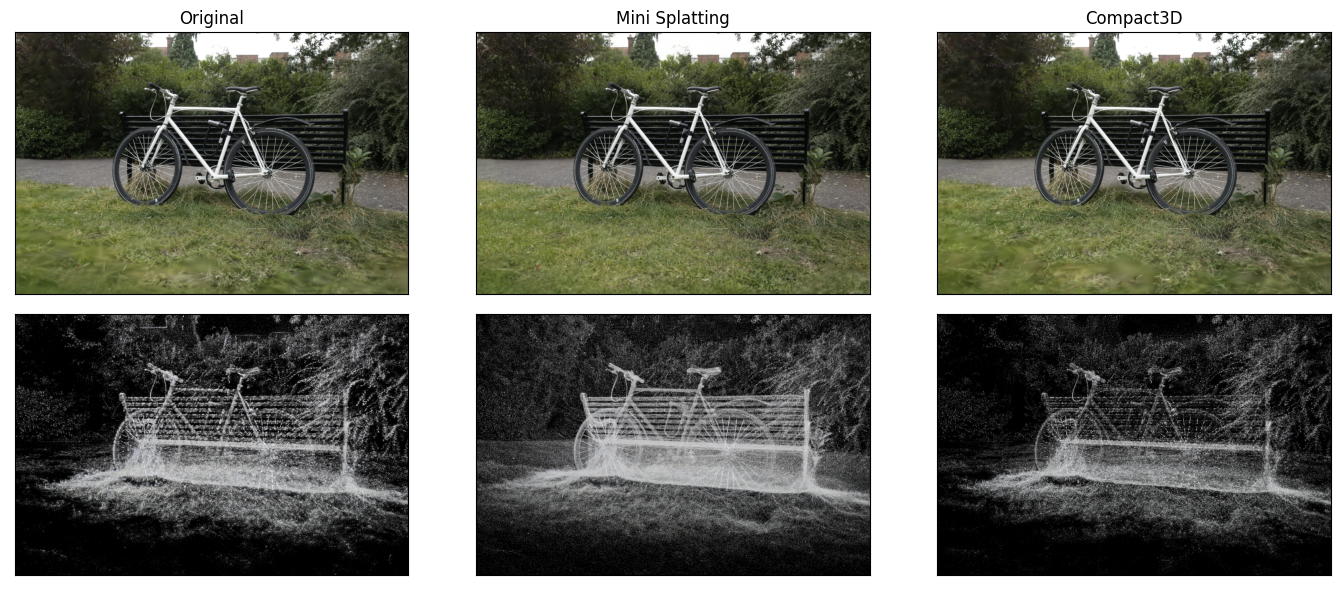

In [ ]:
# Plot the density (where are gaussians where not) for a specific image from the bicycle dataset for Original,Mini Splatting and Compact3D
fig,axs = plt.subplots(2,3)
remove_ticks = lambda *axs : [(ax.set_xticks([]),ax.set_xticklabels([]),ax.set_yticks([]),ax.set_yticklabels([])) for ax in axs]
axs[0][0].imshow(Image.open(os.path.join(eval_paths["orig"]["orig"]["bicycle"],"renders","00000.png")))
axs[0][1].imshow(Image.open(os.path.join(eval_paths["mini"]["orig"]["bicycle"],"renders","00000.png")))
axs[0][2].imshow(Image.open(os.path.join(eval_paths["compact3d"]["orig"]["bicycle"],"renders","00000.png")))

axs[1][0].imshow(Image.open(os.path.join(eval_paths["orig"]["orig"]["bicycle"],"density","00000.png")))
axs[1][1].imshow(Image.open(os.path.join(eval_paths["mini"]["orig"]["bicycle"],"density","00000.png")))
axs[1][2].imshow(Image.open(os.path.join(eval_paths["compact3d"]["orig"]["bicycle"],"density","00000.png")))
remove_ticks(*[ax for ax in axs.flatten()])

axs[0][0].set_title("Original")
axs[0][1].set_title("Mini Splatting")
axs[0][2].set_title("Compact3D")


fig.set_size_inches(14,7)
fig.tight_layout()

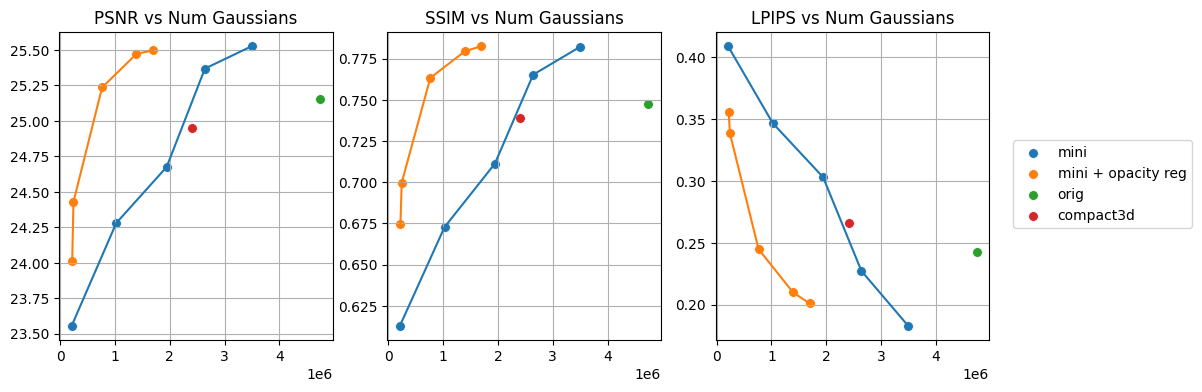

In [4]:
# Plot (PSNT,SSIM,LPIPS) vs num Gaussians for the bicycle dataset
fig,axs = plt.subplots(1,3)
colors = list(sns.color_palette())
for x,y in enumerate(["psnr","ssim","lpips"]):
    sns.scatterplot(x=[stats[f"mini_{i}"]["orig"]["bicycle"]["num_gaussians"] for i in [1,3,5,7,8]],y=[stats[f"mini_{i}"]["orig"]["bicycle"][y] for i in [1,3,5,7,8]],color=colors[0],ax=axs[x],s=50,label="mini")
    sns.lineplot(x=[stats[f"mini_{i}"]["orig"]["bicycle"]["num_gaussians"] for i in [1,3,5,7,8]],y=[stats[f"mini_{i}"]["orig"]["bicycle"][y] for i in [1,3,5,7,8]],color=colors[0],ax=axs[x])

    sns.scatterplot(x=[stats[f"mini_opacity_{i}"]["orig"]["bicycle"]["num_gaussians"] for i in [1,2,5,6,7]],y=[stats[f"mini_opacity_{i}"]["orig"]["bicycle"][y] for i in [1,2,5,6,7]],color=colors[1],ax=axs[x],s=50,label="mini + opacity reg")
    sns.lineplot(x=[stats[f"mini_opacity_{i}"]["orig"]["bicycle"]["num_gaussians"] for i in [1,2,5,6,7]],y=[stats[f"mini_opacity_{i}"]["orig"]["bicycle"][y] for i in [1,2,5,6,7]],color=colors[1],ax=axs[x])
    
    sns.scatterplot(x=[stats[f"orig"]["orig"]["bicycle"]["num_gaussians"]],y=[stats[f"orig"]["orig"]["bicycle"][y]],ax=axs[x],s=50,color=colors[2],label="orig")
    sns.scatterplot(x=[stats[f"compact3d"]["orig"]["bicycle"]["num_gaussians"]],y=[stats[f"compact3d"]["orig"]["bicycle"][y]],ax=axs[x],s=50,color=colors[3],label="compact3d")
    #sns.scatterplot(x=[stats[f"compact3d_noscale"]["orig"]["bicycle"]["num_gaussians"]],y=[stats[f"compact3d_noscale"]["orig"]["bicycle"][y]],ax=axs[x],s=50,color=colors[3],label="compact3d noscale")
    #sns.scatterplot(x=[stats[f"orig_opacity"]["orig"]["bicycle"]["num_gaussians"]],y=[stats[f"orig_opacity"]["orig"]["bicycle"][y]],ax=axs[x],s=50,color=colors[4],label="orig + opacity reg")
    #sns.scatterplot(x=[stats[f"mini_compact3d"]["orig"]["bicycle"]["num_gaussians"]],y=[stats[f"mini_compact3d"]["orig"]["bicycle"][y]],ax=axs[x],s=50,color=colors[5],label="mini + compact3d")
    axs[x].grid(True)
    axs[x].get_legend().remove()

axs[0].set_title("PSNR vs Num Gaussians")
axs[1].set_title("SSIM vs Num Gaussians")
axs[2].set_title("LPIPS vs Num Gaussians")

handles, labels = axs[0].get_legend_handles_labels()

fig.legend(handles,labels,loc='center right',ncol=1,frameon=True,bbox_to_anchor=(1.075, 0.5),)

fig.set_size_inches(12,4)

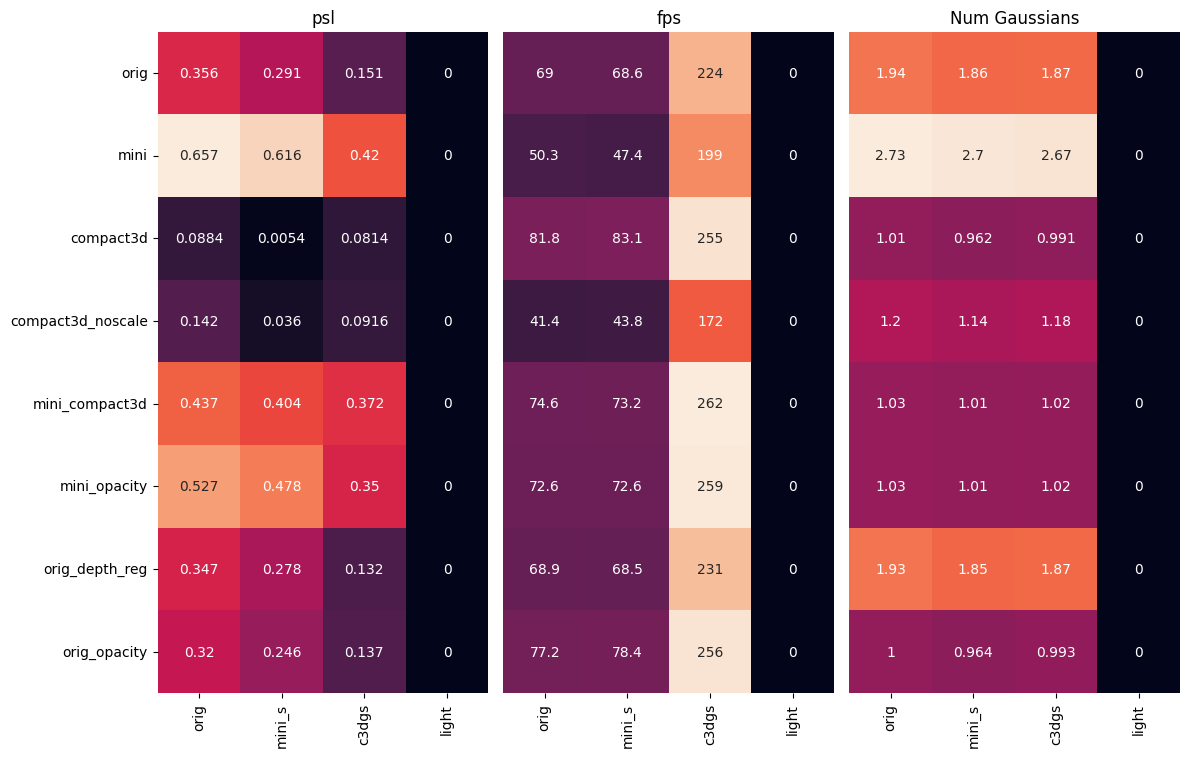

In [ ]:
exps = ["orig","mini","compact3d","compact3d_noscale","mini_compact3d","mini_opacity","orig_depth_reg","orig_opacity"]
compressions = ["orig","mini_s","c3dgs","light"]

table_stats = copy.deepcopy(stats)
table_stats = {key : {comp_key : comp_val for comp_key,comp_val in val.items() if comp_key in compressions} for key,val in table_stats.items() if key in exps}
table_stats_normalized,table_min_max = normalize_stats(table_stats,datasets)
merge_psnr_ssim_lpips(table_stats_normalized)

fig,axs = plt.subplots(1,3,sharex=True)
axs = axs[None,:]
for x,y in enumerate(["psl","fps","num_gaussians"]):
    data = np.zeros((len(exps),4))
    ratio = np.zeros((len(exps),4))
    norm = np.ones_like(data)
    for dx,exp in enumerate(exps):
        for dy,compression in enumerate(compressions):
            for ds in datasets:
                if y == "psl":
                    tbst = table_stats_normalized
                else:
                    tbst = table_stats
                if compression in tbst[exp].keys():
                    if ds in tbst[exp][compression].keys():
                        if y in tbst[exp][compression][ds].keys():
                            data[dx,dy] += tbst[exp][compression][ds][y]
                            norm[dx,dy] += 1
    data = data/norm
    
    if y == "num_gaussians":
        data /= 1e6

    if x == 0:
        sns.heatmap(data,ax=axs[0][x],yticklabels=exps,xticklabels=compressions,cbar=False,annot=True,square=True,fmt='.3g')
    else:
        sns.heatmap(data,ax=axs[0][x],yticklabels=[],xticklabels=compressions,cbar=False,annot=True,square=True,fmt='.3g')


axs[0][0].set_title("PSL")
axs[0][1].set_title("FPS")
axs[0][2].set_title("Num. Gaussians")

fig.set_size_inches(12,12)
fig.tight_layout()

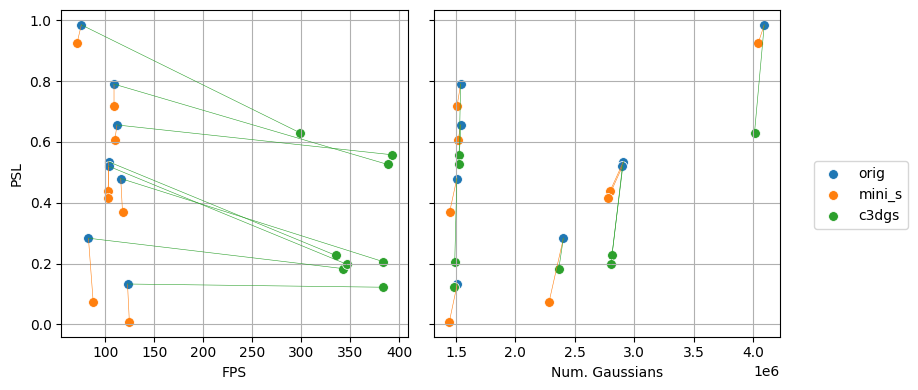

In [65]:
exps = ["orig","mini","compact3d","compact3d_noscale","mini_compact3d","mini_opacity","orig_depth_reg","orig_opacity"]
compressions = ["orig", "mini_s","c3dgs"]
vslabels = ["psl","fps","num_gaussians"]
fig,axs = plt.subplots(1,len(vslabels)-1,sharey="all")
axs = axs[None,:]
colors = list(sns.color_palette())

data = {comp : {vslabel : {} for vslabel in vslabels} for comp in compressions}
for dy,compression in enumerate(compressions):
    for x,y in enumerate(vslabels):
        for dx,exp in enumerate(exps):
            data_alloc = []
            for ds in datasets:
                if y == "psl":
                    tbst = table_stats_normalized
                else:
                    tbst = table_stats
                if compression in tbst[exp].keys():
                    if ds in tbst[exp][compression].keys():
                        if y in tbst[exp][compression][ds].keys():
                            data_alloc.append(tbst[exp][compression][ds][y])
                            
            data_alloc = np.asarray(data_alloc).mean()
            data[compression][y][exp] = data_alloc

for k,vslabel in enumerate(vslabels[1:]):
    for i,comp in enumerate(compressions):
        x_data = [data[comp][vslabel][exp] for exp in exps]
        y_data = [data[comp]["psl"][exp] for exp in exps]
        
        if comp != "orig":
            x_data_orig = [data["orig"][vslabel][exp] for exp in exps]
            y_data_orig = [data["orig"]["psl"][exp] for exp in exps]
            for (x1,y1,x2,y2) in zip(x_data,y_data,x_data_orig,y_data_orig):
                sns.lineplot(x=[x1,x2],y=[y1,y2],ax=axs[0][k],color=colors[i],linewidth=0.4)
        
        sns.scatterplot(x=x_data,y=y_data,ax=axs[0][k],s=50,color=colors[i],label=comp)

handles, labels = axs[0][0].get_legend_handles_labels()

fig.legend(handles,labels,loc='center right',ncol=1,frameon=True,bbox_to_anchor=(1.15, 0.5),)

axs[0,0].grid(True),axs[0,1].grid(True)
axs[0,0].get_legend().remove(),axs[0,1].get_legend().remove()

axs[0,0].set_ylabel("PSL")
axs[0,0].set_xlabel("FPS")
axs[0,1].set_xlabel("Num. Gaussians")

fig.set_size_inches(8,4)
fig.tight_layout()
